<br/>

# <font color=teal>Ecommerce Shopping Project</font>

This project is based on the Amazon KDD Cup 2023 challenge to classify customer shopping queries as related or not related to product descriptions

find the challenge [Here](https://www.aicrowd.com/challenges/amazon-kdd-cup-23-multilingual-recommendation-challenge)

<br/>


### <font color=teal>Goal</font>
This project will focus on Task 1 of the challenge : 'Next Product Recommendation'

This notebook performs the data analysis and EDA for the project

<br/>


### <font color=teal>Input</font>
Hugging face Shopping Session Dataset : [Datasets](https://www.aicrowd.com/challenges/amazon-kdd-cup-23-multilingual-recommendation-challenge/problems/task-3-next-product-title-generation#dataset)


The ```query``` (train) data contains customer shopping queries, with pointers to a product_id and a lable showing how close or far the query is from an actual product


The ```products``` (product) data contains product descriptions

<br/>


### <font color=teal>Approach</font>
 
Use the pre-trained hugging-face ```sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2``` model 

Create query and product description 'pairs' -- keeping the label showing how well the query relates to the product.

We'll use this prepared data in subsequent steps to train the model and make predictions


<br/>

<br/>

### <font color=teal>Output</font>

<font color=purple> Raw data downloaded from hugging face</font>

`DATA`
└── `raw`
    ├── `product_catalogue-v0.3.csv.zip`
    └── `train-v0.3.csv.zip`


<font color=purple>Data prepared for training</font>

`DATA`
├── `prep`
│   ├── `es`
│   │   ├── `es_prod_query_0.parquet`
│   │   ├── `es_prod_query_1.parquet`
│   │   ├── `es_prod_query_2.parquet`
│   │   ├── `es_prod_query_3.parquet`
│   │   └── `es_prod_query_4.parquet`
│   ├── `jp`
│   │   ├── `jp_prod_query_0.parquet`
│   │   ├── `jp_prod_query_1.parquet`
│   │   ├── `jp_prod_query_2.parquet`
│   │   ├── `jp_prod_query_3.parquet`
│   │   ├── `jp_prod_query_4.parquet`
│   │   └── `jp_prod_query_5.parquet`
│   ├── `metadata.json`
│   └── `us`
│       ├── `us_prod_query_0.parquet`
│       ├── `us_prod_query_1.parquet`
│       ├── `us_prod_query_2.parquet`
│       ├── `us_prod_query_3.parquet`
│       ├── `us_prod_query_4.parquet`
│       └── `us_prod_query_5.parquet`




---


#### <a id="top"></a>

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Table of contents</h3>
</div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">
<ul>
    <li><a href="#0" target="_self" rel=" noreferrer nofollow">0. Imports and housekeeping</a></li>
    <li><a href="#1" target="_self" rel=" noreferrer nofollow">1. AI Crowd Login</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">2. Load and Review the query data</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">3. Load and Review the product data</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">4. Merge the query and product tables</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">5. Prepare the data for our NLP transformer</a></li>
    <li><a href="#2" target="_self" rel=" noreferrer nofollow">6. Save our prepared data</a></li>
</ul>
</div>

<a id="0"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Imports and housekeeping</h3>
</div>

In [1]:
# !pip install aicrowd-cli
# !pip install transformers datasets

In [2]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import pandas as pd
import os

from transformers import AutoTokenizer,create_optimizer

# Local
from project_secrets.secrets import get_secret
from notebooks.jupyter_util import conditional_download
from notebooks.jupyter_util import get_file_path



<a id="1"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">AI Crowd Login</h3>
</div>

Get the AI crown key from 'secrets' source

In [3]:
api_key = get_secret('api_key')
os.environ["AICROWD_API_KEY"] = api_key

Login

In [4]:
! aicrowd login 

API Key valid
Gitlab oauth token invalid or absent.
It is highly recommended to simply run `aicrowd login` without passing the API Key.
Saved details successfully!


Download data from hugging face if we don't already have it

In [5]:

conditional_download('train-v0.3.csv.zip')
conditional_download('product_catalogue-v0.3.csv.zip')

File exists:  /Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/capstone3/data/raw/train-v0.3.csv.zip
File exists:  /Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/capstone3/data/raw/product_catalogue-v0.3.csv.zip



<a id="2"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Load and Review the query data</h3>
</div>



The query table contains 781744 rows and 5 columns

It contains shopping queries in english, spanish and japanese.  Each query has a product_id that can be linked to a product description.

Each query has an esci_lable that tells us how well the query matches the product_id. 


<br/>

|---|---|
|exact|The query matches the product_id exactly |
|irrelevant|The query does NOT match the product_id at all|
|substitute|The product_id would be a reasonable substitute|
|complement|The product_id would be a reasonable complement - usrs also purchased ...|





There are no missing values

There are two categorical columns
- esci_label contains the text label we'll use
- The query_locale column contains 'us', 'es', and 'jp' locales

The ecsi_labels are not perfectly balanced, but we'll see how well the model trains before augmenting

There are a few questionable query + product combinations, but only one that has a different label for the same query+product

The query_id key is not useable as a key or index


<font color=teal>Load the query data</font>

In [6]:


train_file = get_file_path('raw_data', 'train-v0.3.csv.zip')
query_df = pd.read_csv(train_file, compression='zip')

<font color=teal>what is the shape of the data?</font>

In [7]:
query_df.shape

(781744, 5)

<font color=teal>What are the data types?</font>

In [8]:
query_df.dtypes

query_id         int64
query           object
query_locale    object
product_id      object
esci_label      object
dtype: object

<font color=teal>There are no null values</font>

In [9]:
query_df.isna().sum()

query_id        0
query           0
query_locale    0
product_id      0
esci_label      0
dtype: int64

<font color=teal>Two categorical columns and three continuous columns</font>
- the product id is many to one with the query (query_id and query)
- there's a mismatch with query_id and query -- should they have the same count?

In [10]:
query_df.nunique()

query_id         33804
query            33777
query_locale         3
product_id      643908
esci_label           4
dtype: int64

<font color=teal>The data is a little unbalanced</font>

In [11]:
df = query_df[[  'query_locale', 'esci_label']].value_counts().sort_index(level='query_locale').unstack()

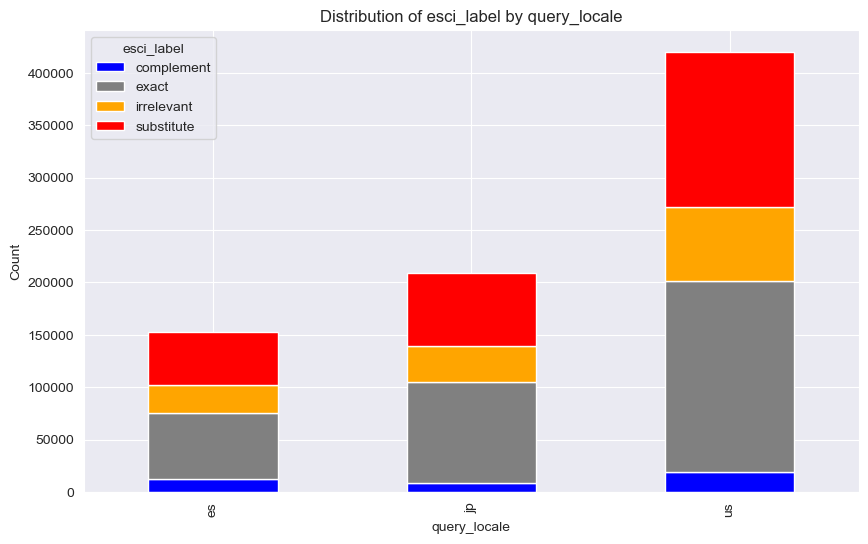

In [12]:
# Define custom colors for each esci_label
custom_colors = {
    'complement': 'blue',
    'exact': 'gray',
    'irrelevant': 'orange',
    'substitute': 'red'
}

# Plot a stacked bar chart with custom colors
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), color=[custom_colors.get(col, 'gray') for col in df.columns])

# Customize the chart
plt.title('Distribution of esci_label by query_locale')
plt.xlabel('query_locale')
plt.ylabel('Count')
plt.legend(title='esci_label')

# Show the chart
plt.show()

<font color=teal>There are minor errors in the query + product_id combinations</font>


- There are 12 duplicate query + product combinations -- this is ok
- There is one case where the query and product_id are the same, but the label is different between spanish and english [see below]   -- this might be valid, and it's only one record, but I think we may want to train separately for different locales if they do have different logic

There are 12 duplicate query + product combinations – this is ok

In [13]:
# get just the query + product combinations
query_product_combinations =  query_df[['query', 'product_id']]

# find out if there are any duplicate combinations
duplicate_rows = query_product_combinations[query_product_combinations.duplicated(keep=False)]
duplicate_rows.sort_values(by='query')


,query,product_id
69257,chanca piedra,B071KR997R
644658,chanca piedra,B071KR997R
123141,gopro hero 8,B07XP44MTV
437718,gopro hero 8,B07XP44MTV
253021,stranger,0679720200
582824,stranger,0679720200
293813,wyze cam v2,B0763358FV
293815,wyze cam v2,B07DGR98VQ
460911,wyze cam v2,B0763358FV
460913,wyze cam v2,B07DGR98VQ


<font color=teal>manually inspection of the duplicates shows at least one inconsistency</font>

In [14]:
query_df.loc[(query_df['query'] == 'gopro hero 8') & (query_df['product_id'] == 'B07XP44MTV')]

,query_id,query,query_locale,product_id,esci_label
123141,5107,gopro hero 8,us,B07XP44MTV,exact
437718,19664,gopro hero 8,es,B07XP44MTV,complement


<font color=teal>find how many query + product_id combinations have differing labels</font>
- ok, so there's only one

In [15]:

# Group by 'query' and 'product_id' and count the number of unique labels
unique_labels_count = query_df.groupby(['query', 'product_id'])['esci_label'].nunique()

# Find the combinations with more than one unique label
differing_labels = unique_labels_count[unique_labels_count > 1]

# Display the combinations with differing labels
differing_labels

query         product_id
gopro hero 8  B07XP44MTV    2
Name: esci_label, dtype: int64

<font color=teal>The query_id is not consistent</font>
- the same query_id can refer to different query values

In [16]:
query_combinations =  query_df[['query_id', 'query']].drop_duplicates()

duplicate_query_values = query_combinations.groupby('query')['query_id'].transform('nunique') > 1
result = query_combinations[duplicate_query_values].sort_index(level='query_id')
result

,query_id,query
0,0,# 2 pencils not sharpened
16,1,# 2 pencils not sharpened
40,1,# mom life
55,2,# mom life
56,2,#1 best and not expensive bath back brush crea...
...,...,...
781687,33800,財布 小銭入れなし メンズ
781703,33801,財布 小銭入れなし メンズ
781704,33801,針なしほっちきす
781719,33802,針なしほっちきす



<a id="3"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Load and Review the products data</h3>
</div>


This table has more information about each product.  It has title and descriptions, and a product_id that we want to use to merge with the queries table

We will only use the product_title 

Our ultimate goal is to predict the right product based on the customer query.   

We'll use this data to train the model to use the customers query to point to the right products.

We'll do that by training the model using the query text + the related product title text, and we already have a label that tells us how well the query relates to the product.

We are only using the product_title in this application, so lets just make sure that we can merge to the queries

<font color=teal> Load the products table</font>

In [17]:
product_file = get_file_path('raw_data', 'product_catalogue-v0.3.csv.zip')
product_df = pd.read_csv(product_file, compression='zip')

In [18]:
product_df.shape

(883868, 7)

<font color=teal>There are many null product cells, but we are only using 

- The product_id that we'll use to join the queries
- The product_title which has a few nulls that we can impute later when we merge

In [19]:
product_df.isna().sum()

product_id                   0
product_title              149
product_description     437158
product_bullet_point    144672
product_brand            75941
product_color_name      350208
product_locale               0
dtype: int64

<a id="4"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Merge the query and product tables</h3>
</div>

In [20]:
trial_merge = pd.merge(query_df, product_df, on='product_id', how='outer', indicator=True)

<font color=teal>The data joins well</font>

There are many products that have no customer queries (right-only) - and that's fine

But there are no queries that do not link to valid products (left-only) , so we can just inner join queries to products

In [21]:
trial_merge['_merge'].value_counts()

both          793378
right_only    235625
left_only          0
Name: _merge, dtype: int64

<font color=teal>Perform the inner join from query to product</font>

In [22]:
df = pd.merge(query_df, product_df, on='product_id', how='inner')


<font color=teal>Filter just the columns we need</font>

In [23]:
df = df[['query', 'product_title', 'esci_label', 'query_locale']]

<font color=teal>Encode the text label column</font>

In [24]:

df['label'] = np.where(df['esci_label'] == 'exact', 1.0,
             np.where(df['esci_label'] == 'substitute', 0.6,
             np.where(df['esci_label'] == 'complement', 0.3, 0.0)))

In [25]:
df[['label', 'esci_label']].drop_duplicates()

,label,esci_label
0,1.0,exact
2,0.6,substitute
4,0.0,irrelevant
14,0.3,complement


<font color=teal>Drop and rename columns</font>

In [26]:
# get rid of the text esci_label - we replaced it with label
df.drop(columns=['esci_label'], inplace=True)

# rename product_title to just product
df.rename(columns={
    'product_title': 'product'
},  inplace=True)



<font color=teal>Impute the 149 missing product titles</font>

In [27]:
# impute the 149 missing product titles to be the same as the query - there are not too many of these, but they are all false positives, so maybe we should just drop them???
# df['product'].dropna().fillna(df['query'], inplace=True)

df = df.dropna(subset=['product'])

df.isna().sum()

query           0
product         0
query_locale    0
label           0
dtype: int64

<a id="5"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Prepare the data for our NLP transformer</h3>
</div>


Use the hugging-face ```sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 model```

Get the tokenizer and encode our query and product columns 



In [28]:
BATCH_SIZE=128
MAX_LENGTH=64
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [29]:
model_id="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [30]:
# Load the Parquet file into a pandas DataFrame

# Tokenize 'query' and 'product' columns using the BERT tokenizer
tokenized_query = tokenizer(df['query'].tolist(), max_length=MAX_LENGTH, padding='max_length', truncation=True)
tokenized_product = tokenizer(df['product'].tolist(), max_length=MAX_LENGTH, padding='max_length', truncation=True)

# Add tokenized outputs to the DataFrame
df['input_ids_query'] = tokenized_query['input_ids']
df['token_type_ids_query'] = tokenized_query['token_type_ids']
df['attention_mask_query'] = tokenized_query['attention_mask']
df['input_ids_product'] = tokenized_product['input_ids']
df['token_type_ids_product'] = tokenized_product['token_type_ids']
df['attention_mask_product'] = tokenized_product['attention_mask']


In [31]:
df.dtypes

query                      object
product                    object
query_locale               object
label                     float64
input_ids_query            object
token_type_ids_query       object
attention_mask_query       object
input_ids_product          object
token_type_ids_product     object
attention_mask_product     object
dtype: object

<a id="6"></a>
<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Save our prepared data</h3>
</div>


Save locales separately

Break the data into chunks

Save the meta-data 


<font color=teal>data directory</font>
.
├── prep
│   ├── es
│   │   ├── es_prod_query_0.parquet
│   │   ├── es_prod_query_1.parquet
│   │   ├── es_prod_query_2.parquet
│   │   ├── es_prod_query_3.parquet
│   │   └── es_prod_query_4.parquet
│   ├── jp
│   │   ├── jp_prod_query_0.parquet
│   │   ├── jp_prod_query_1.parquet
│   │   ├── jp_prod_query_2.parquet
│   │   ├── jp_prod_query_3.parquet
│   │   ├── jp_prod_query_4.parquet
│   │   └── jp_prod_query_5.parquet
│   └── us
│       ├── us_prod_query_0.parquet
│       ├── us_prod_query_1.parquet
│       ├── us_prod_query_2.parquet
│       ├── us_prod_query_3.parquet
│       ├── us_prod_query_4.parquet
│       └── us_prod_query_5.parquet
│   ├── <font color=yellow>metadata.json</font>



In [32]:
from typing import List
from notebooks.config import get_directory

def write_chunks(input_df: pd.DataFrame, locale) -> List[str]:
    print("writing files for locale ", locale )
    files = []
    stage_dir = os.path.join(get_directory('prep_data'), locale)
    if not os.path.exists(stage_dir):
        os.makedirs(stage_dir)

    df_locale = input_df.loc[input_df.query_locale==locale].drop(columns=['query_locale'])
    # df_locale.drop(columns=['query_locale'], inplace=True)
    
    # Define the number of chunks you want
    num_chunks = 5  # Adjust this number as needed
    
    # Calculate the chunk size
    chunk_size = len(df_locale) // num_chunks
    
    # Split the DataFrame into smaller chunks
    chunks = [df_locale[i:i + chunk_size] for i in range(0, len(df_locale), chunk_size)]
    
    # Save each chunk as a separate Parquet file
    for i, chunk in enumerate(chunks):
        file_name = os.path.join(stage_dir, f'{locale}_prod_query_{i}.parquet')
        # print("\t", file_name)
        files.append(file_name)
        chunk.to_parquet(file_name)
    return files


In [33]:
us_files = write_chunks(df, 'us')
jp_files = write_chunks(df, 'jp')
es_files = write_chunks(df, 'es')

writing files for locale  us
writing files for locale  jp
writing files for locale  es


<font color=teal>Save the file names as meta-data so we can use them later</font>

In [34]:
import json

meta_file = os.path.join(get_directory('prep_data'), 'metadata.json')

meta_data = {
    'us': us_files,
    'jp': jp_files,
    'es': es_files
}

with open(meta_file, 'w') as fp:
    json.dump(meta_data, fp)
